# Investigating the Impact of Basis Quality on Leverage-Based Sample Selection

## Abstract

In this work, we study how basis quality influences leverage-based sample selection by comparing three classes of representations on MNIST: raw pixel features, random ReLU features, and convolutional neural networks with identical architectures but different random initializations. For each basis, we compute leverage scores and evaluate their effectiveness by training only on the top-k leverage points and measuring training accuracy as a function of k.

## Features

We consider three types of feature representations for the MNIST dataset:
1. **Raw Pixel Features**: The original pixel values of the images.
2. **Random ReLU Features**: Features generated by applying random ReLU transformations to the raw pixel data.
3. **Convolutional Neural Network (CNN) Features**: Features extracted from a CNN with the same architecture but different random initializations.
    - CNN A1-A5: Randomly initialized weights. Trained to do classification.
    - CNN B1-B5: Randomly initialized weights. Trained to do regression.
    - CNN C1-C5: Randomly initialized weights. Not trained.

## Investigations

### Question 1: How do different basises affect leverage-based sample selection?
1. **Leverage Score Computation**: For each feature representation, we compute the leverage scores of the training samples.
2. **Sample Selection**: We select the top-k samples based on their leverage scores.
3. **Model Training**: We train a classifier using only the selected top-k samples.
4. **Evaluation**: We evaluate the training accuracy as a function of k, the number of selected samples.

### Question 2: Do neural network prioritize the same samples across different random initializations? (In other words, are the leverage scores correlated across different random initializations? Is the idea of leverage score robust to random initialization?)

1. **Varying Basis Quality**: We systematically vary the quality of the basis by using different random initializations for the CNNs.
2. **Correlation Analysis**: We analyze the correlation of leverage scores across different random initializations to assess the robustness of leverage-based sample selection. (Measure the swap distance/rank correlation between leverage score rankings. Are they similar to each other? To random shuffling?)
3. **Sample Overlap**: We measure the overlap in selected samples across different random initializations to understand if certain samples are consistently prioritized.

# Question 1

# Question 2

In [2]:
import torch
import numpy as np
from mnist_embeddings import MnistConvNet


# Random ReLU Features
def relu_features(X, features=200) -> torch.Tensor:
    N, *_ = X.shape
    X = X.reshape(N, -1)
    W = torch.randn(X.shape[1], features, device=X.device)
    return torch.relu(X @ W) / np.sqrt(features)


from torchvision.datasets import MNIST


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", DEVICE)

MNIST_TRAIN = MNIST(
    root="~/Desktop/AliasingOperatorExperiments/data", train=True, download=True
)
MNIST_TEST = MNIST(
    root="~/Desktop/AliasingOperatorExperiments/data", train=False, download=True
)

mnist_X = MNIST_TRAIN.data.float().to(DEVICE).reshape(-1, 1, 28, 28) / 255.0
mnist_y = MNIST_TRAIN.targets.to(DEVICE)
test_mnist_X = MNIST_TEST.data.float().to(DEVICE).reshape(-1, 1, 28, 28) / 255.0
test_mnist_y = MNIST_TEST.targets.to(DEVICE)

combined_mnist_X = torch.cat([mnist_X, test_mnist_X], dim=0)
combined_mnist_y = torch.cat([mnist_y, test_mnist_y], dim=0)


import numpy as np
import torch

BASIS_FUNCTIONS = 200


# Embed the testing set (not the training set)
def embed_dataset(X, model, device, basics_functions=BASIS_FUNCTIONS):
    # Embed the data using the convolutional layers of the network
    embeddings = torch.tensor(
        np.zeros(
            (
                X.shape[0],
                basics_functions,
            )
        )
    ).to(device)

    with torch.no_grad():
        for batch_start in range(0, X.shape[0], 256):
            batch_end = min(batch_start + 256, X.shape[0])
            batch = X[batch_start:batch_end].to(device)
            batch_embeddings = model.embed(batch)
            embeddings[batch_start:batch_end] = batch_embeddings
    return embeddings


def load_model_embed_data(path: str):
    state = torch.load(path)
    net = MnistConvNet()
    net.load_state_dict(state)
    net.to(DEVICE)
    net.eval()
    embeddings = embed_dataset(combined_mnist_X, net, DEVICE, BASIS_FUNCTIONS)
    return embeddings


# Embeddings
LABELS = combined_mnist_y
RAW = combined_mnist_X.reshape(-1, 28 * 28)
RELU_FEATURES = relu_features(combined_mnist_X, features=RAW.shape[1])
CNN_EMBEDDINGS = {}

import glob

for path in glob.glob("mnist-cnn-*.pth"):
    _, __, letter, hsh = path[:-4].split("-")
    print("loading", letter, "from", path)
    CNN_EMBEDDINGS[letter] = load_model_embed_data(path)

using cuda
loading B2 from mnist-cnn-B2-d33ec18ec317ceb834e70900948cebf5349cd694b8e60c2fa01df671d884c6e9.pth
loading A5 from mnist-cnn-A5-281c64ae0e093b5f25c74f563ab8df4816f691dac7192a6080025a1a5c5a5ea6.pth
loading C5 from mnist-cnn-C5-c781165b907876e4f528a451dc3f19f050d02430e024720c6d3234531c53d520.pth
loading A1 from mnist-cnn-A1-93d77c3a55680289cf891cc6aa9c777a4068913c3d94f6a12ca8e800343c4ed2.pth
loading A3 from mnist-cnn-A3-380064bbb68441c4a2d1846554f2eeef13008958975970e7128c168f9ecf3afe.pth
loading C2 from mnist-cnn-C2-5f0b018253844c6bc343087e0574368a8b3ba29212822abb485bca5491bc7305.pth
loading C1 from mnist-cnn-C1-c837d179d75114e9d075463863a69b3c29d89a6a5b58caf55ff0ca10db357247.pth
loading A4 from mnist-cnn-A4-b5afb85682d831c18f3cbb7fe5248165c77495ef8b708cb5c60e640db5cf706f.pth
loading C4 from mnist-cnn-C4-b0f6d55cba7a0bf5656a5177ee36bacfceefe3da2d6fc9ea7cb3f60d8ada3e1a.pth
loading B3 from mnist-cnn-B3-0a6871e7460a812e7ac48d7db52e642a0bf82cb6848e9c8b20f69cc4590697b8.pth
loading B

In [3]:
def calculate_leverage_scores(X: torch.Tensor) -> torch.Tensor:
    """Calculate the leverage scores for the given data matrix X.

    Args:
        X (torch.Tensor): Data matrix of shape (N, D).
    Returns:
        torch.Tensor: Leverage scores of shape (N,).
    """
    Q, _ = torch.linalg.qr(X, mode="reduced")
    leverage_scores = torch.sum(Q**2, dim=1)
    return leverage_scores

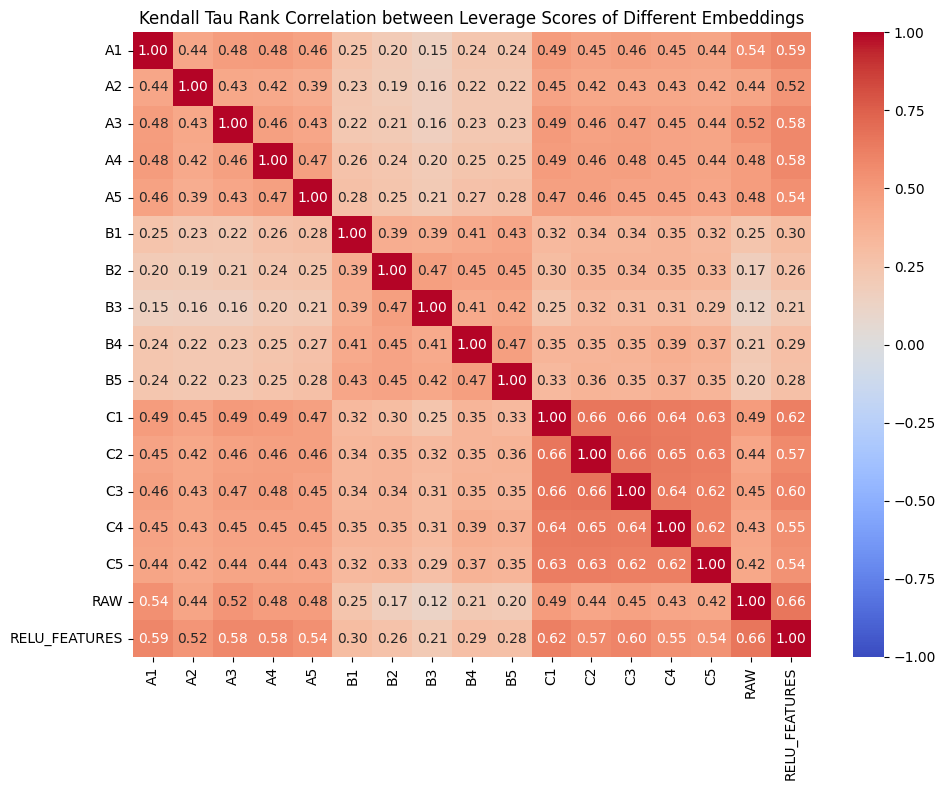

In [8]:
from pathlib import Path


# Measure the weighted Kendall tau rank correlation between leverage scores rankings of different embeddings
from scipy.stats import kendalltau

EMBEDDINGS = ["RAW", "RELU_FEATURES"] + list(CNN_EMBEDDINGS.keys())
LEVERAGE_SCORES = {}
for name, embedding in zip(EMBEDDINGS, [RAW, RELU_FEATURES] + list(CNN_EMBEDDINGS.values())):
    leverage_scores = calculate_leverage_scores(embedding).cpu().numpy()
    LEVERAGE_SCORES[name] = leverage_scores

RANK_CORRELATIONS = {}  # (name, other_name): (tau, p_value)

for i, (name, scores) in enumerate(LEVERAGE_SCORES.items()):
    for j, (other_name, other_scores) in enumerate(LEVERAGE_SCORES.items()):
        if i <= j:
            tau, _ = kendalltau(scores, other_scores)
            RANK_CORRELATIONS[",".join(tuple(sorted([name, other_name])))] = tau

import json

with open(Path("figures/rank_correlations.json"), "w") as f:
    json.dump(RANK_CORRELATIONS, f, indent=4)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Pairplot the rank correlations tau values
correlation_matrix = pd.DataFrame(index=sorted(EMBEDDINGS), columns=sorted(EMBEDDINGS), dtype=float)
for (name_pair, tau) in RANK_CORRELATIONS.items():
    name1, name2 = name_pair.split(",")
    correlation_matrix.loc[name1, name2] = tau
    correlation_matrix.loc[name2, name1] = tau
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.astype(float), annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Kendall Tau Rank Correlation between Leverage Scores of Different Embeddings")
plt.tight_layout()
plt.savefig(Path("figures/rank_correlation_heatmap.png"))
plt.show()